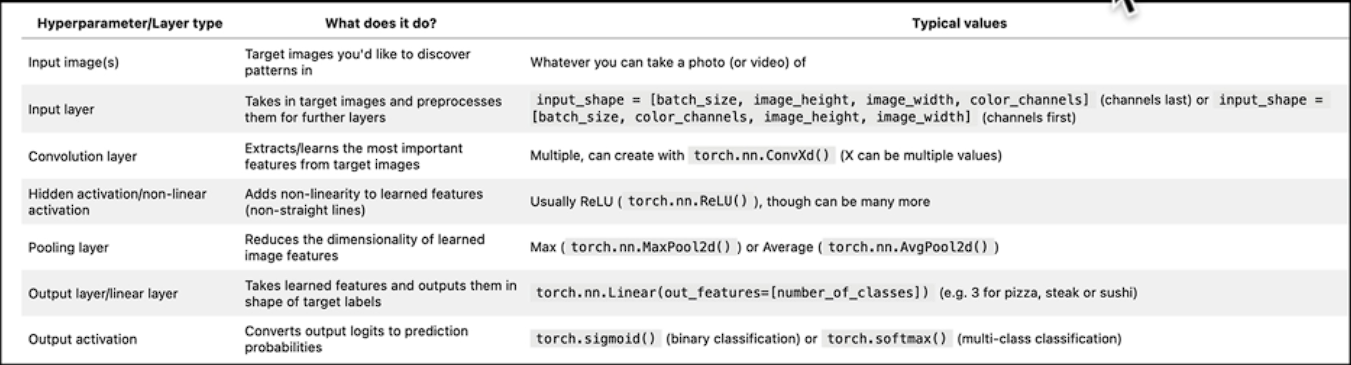

- 'torchvision' - base domain library for computer vision.
- 'torchvision.datasets' - get datasets and data loading functions for computer vision.
- 'torchvision.models' - get pre-trained computer vision models.
- 'torchvision.transforms' - functions for manipulating the vision data.
- 'torch.utils.data.Dataset' - Base dataset class for PyTorch.
- 'torch.utils.data.DataLoader' - Creates a python iterable over the dataset.


In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets 
from torchvision import transforms 
from torchvision.transforms import ToTensor 

import matplotlib.pyplot as plt


The dataset will be Fashion.MNIST

In [2]:
train_data = torchvision.datasets.FashionMNIST(
    root="datasets/",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = torchvision.datasets.FashionMNIST(
    root="datasets/",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
len(train_data),len(test_data)

(60000, 10000)

In [4]:
print(len(train_data[0]))
print(len(train_data[0][0]))
print(len(train_data[0][0][0]))
print(len(train_data[0][0][0][0]))
# len()

2
1
28
28


In [5]:
class_names = train_data.classes
print(class_names)
class_to_idx = train_data.class_to_idx
print(class_to_idx)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In pytorch we have color channels first.

In [6]:
image,label = train_data[0]

print(f"Image Shape: {image.shape} -> [color_channels,height,width]")
print(f"Image Label: {class_names[label]}")

Image Shape: torch.Size([1, 28, 28]) -> [color_channels,height,width]
Image Label: Ankle boot


(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

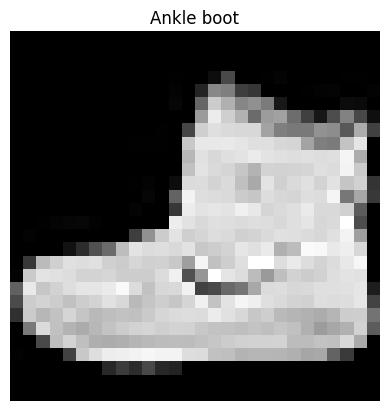

In [7]:
plt.imshow(image.squeeze(),cmap="grey")
plt.title(class_names[label])
plt.axis(False)

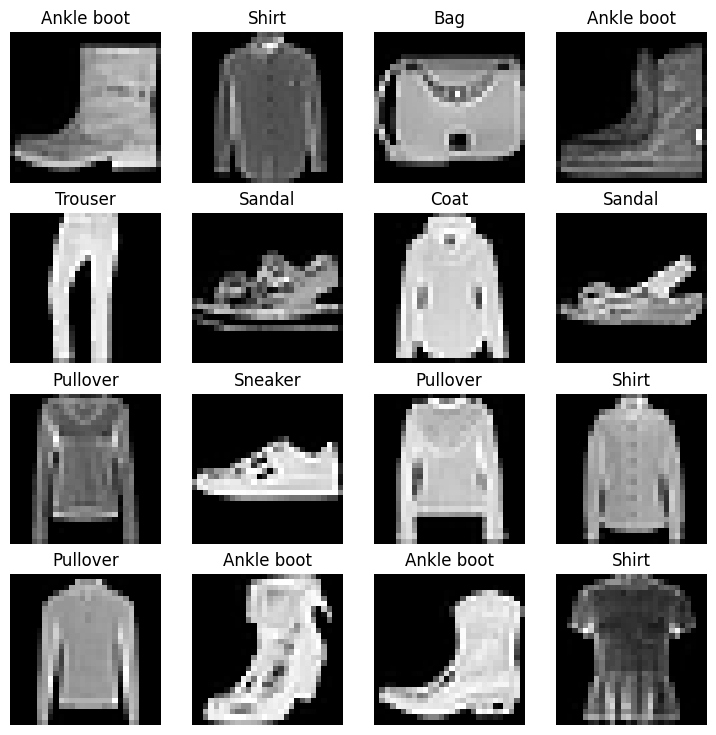

In [8]:
# lets visualize few images

torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4

for i in range(1,rows*cols+1):
    # selecting a random index from the training data
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    img,label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)




Can we make a model with pure linear layers to classify them or do we need non-linearity ?


### Prepare Dataloader 
- Right now, our data is in the form of Pytorch Datasets.
- DataLoader turns our dataset into Python iterable, and as we want to turn our data into mini-batches.
- Why would we do this ?
    - It is more computationally efficient, as in the hardware may not be able to load 60000 train_data images in one hit, so we segregate them into batches. 
    - It gives our neural network more chances to update its gradients per epoch. Lets say if batch-size is 100 then we will have 600 iterations (1 iteration = feed forward + back propagation) per epoch (whole dataset is gone through the model).

Why Use Mini-Batches Instead of the Entire Dataset at Once?
- Memory Efficiency:
    - Limited Hardware Resources:  
        Modern datasets (e.g., the MNIST dataset with 60,000 images) can be too large to fit entirely into GPU or even CPU memory. Loading the whole dataset in one go would require a huge amount of memory.
    - Batch Processing:  
    By splitting the dataset into smaller mini-batches (say, 100 images at a time), you only load a fraction of the dataset into memory. This ensures that the training process is more memory-efficient and can run on hardware with limited memory capacity.
- Computational Efficiency and Faster Convergence:
    - Frequent Updates:  
        When using mini-batches, the neural network updates its weights multiple times per epoch. For example, with 60,000 images and a batch size of 100, you'll perform 600 gradient updates (iterations) per epoch.
    - Faster Convergence:  
        More frequent updates often lead to more stable and sometimes faster convergence, as the network learns from a variety of mini-batches rather than waiting to see the entire dataset before updating.
    - Stochastic Gradient Descent (SGD):
        The process of updating the model based on mini-batches is a form of SGD. This introduces a level of noise into the gradient estimation, which can help the optimizer escape local minima and find better solutions in the loss landscape.
- Practical Training Considerations:
    - Parallel Processing:  
        Mini-batches allow for more efficient use of parallel processing hardware (e.g., GPUs). These devices are designed to perform operations on blocks of data simultaneously, making batch processing inherently efficient.
    - Flexibility:
        Using a DataLoader gives you the flexibility to easily shuffle data, apply data augmentation, and handle different sampling strategies—all crucial for building robust training pipelines.
    - Scalability:  
        By processing data in batches, you can scale your training to very large datasets and distribute the computation over multiple devices or machines if needed.

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle=True
)


In [10]:
print(f"Length of Train DataLoader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of Test DataLoader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of Train DataLoader: 1875 batches of 32
Length of Test DataLoader: 313 batches of 32


In [11]:
print("First Batch Size: ")
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

First Batch Size: 


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

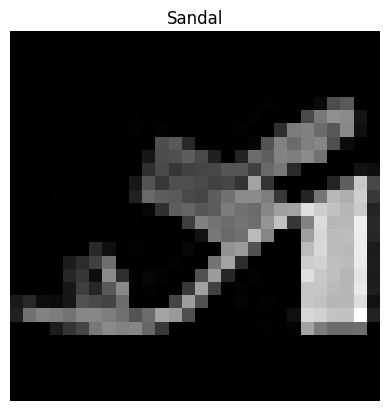

In [12]:
torch.manual_seed(35)

random_idx = torch.randint(0,32,size=[1]).item()
img,label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)


In [13]:
# lets go through flatten model

flatten_model = nn.Flatten()
img1 = train_features_batch[0] # 1st image in the 1st batch
flattened_img = flatten_model(img1)
print(flattened_img.shape)
print(img1.shape)

torch.Size([1, 784])
torch.Size([1, 28, 28])


In [14]:
!nvidia-smi

Mon Feb 24 05:38:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   43C    P3             12W /   30W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
device = "cuda" if torch.cpu.is_available() else "cpu"
device

'cuda'

#### Model 0: Base Line Linear Model

We will build a baseline model which will be a linear model, there the input has to be in 1 dimension so we will use flatten to flatten out dataset.

In [16]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)


In [17]:
torch.manual_seed(40)

# setup model with input params
model_0 = FashionMNISTModelV0(input_shape=784,
                              hidden_units=16,
                              output_shape=len(class_names)).to(device)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [18]:
def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    accuracy = (correct/len(y_pred)) * 100
    return accuracy

In [19]:
dummy_x = torch.rand([1,1,28,28]).to(device)
class_names[torch.argmax(model_0(dummy_x))]

'Ankle boot'

In [20]:
loss_fn0 = nn.CrossEntropyLoss().to(device)
optimizer0 = torch.optim.Adam(params=model_0.parameters(),lr=0.01)

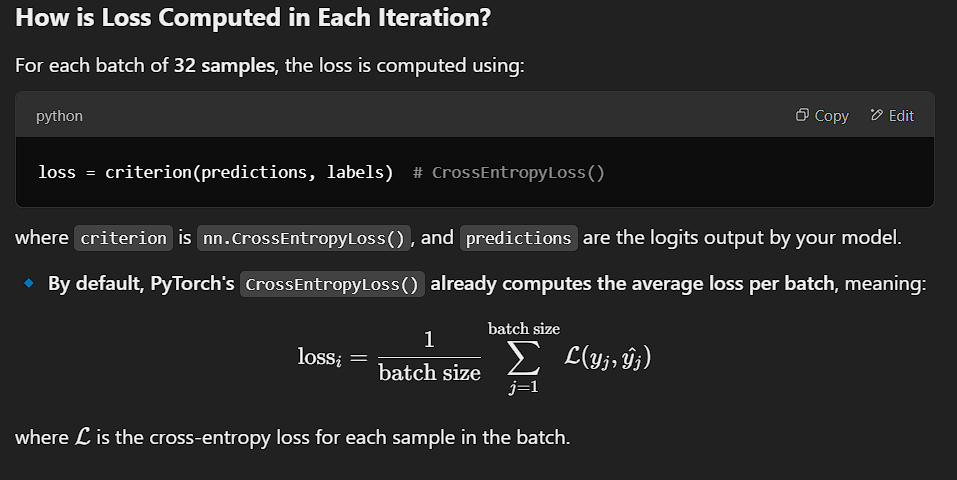
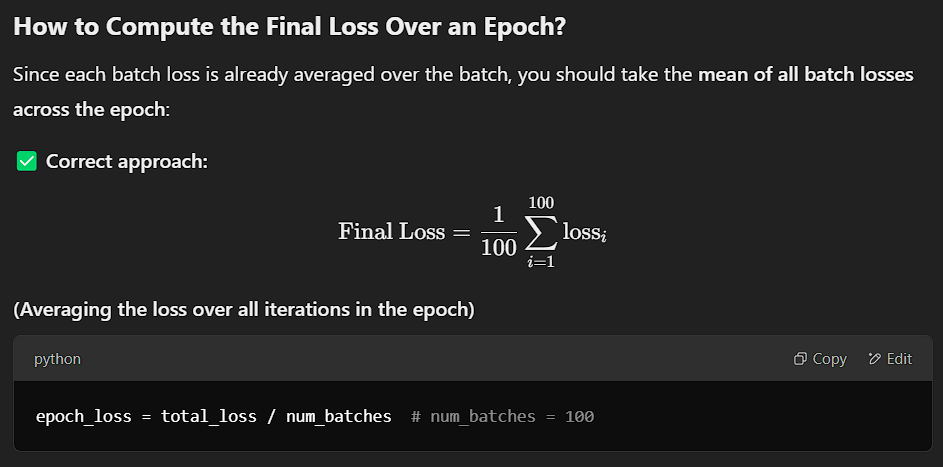
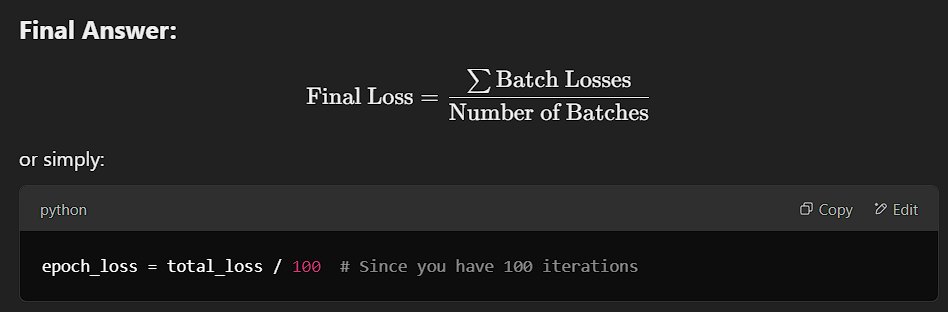

In [21]:
from tqdm.auto import tqdm

def training_step(model: nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: nn.Module,
                  optimizer: torch.optim.Optimizer,
                  epoch: int,
                  device: torch.device = device,) -> list[int]:
    ''' 
        Performs training step on the model with the Data-Loader
    '''
    
    acc_train = 0
    loss_train = 0
    model.train()

    for X,y in tqdm(data_loader, desc=f"Epoch {epoch} Training", leave=False):

        X,y = X.to(device),y.to(device)
        
        y_pred_logits = model(X)
        # print(y_pred_logits.shape)
        y_pred = torch.argmax(y_pred_logits,dim=1)
        # print(y_pred.shape)

        loss = loss_fn(y_pred_logits,y)
        loss_train += loss.item()
        acc_train += accuracy_fn(y,y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return loss_train,acc_train

c:\Users\HP\Desktop\Deep_Learning\Pytorch-For-DeepLearning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
from tqdm.auto import tqdm

def testing_step(model: nn.Module,
                  data_loader: torch.utils.data.DataLoader,
                  loss_fn: nn.Module,
                  epoch: int,
                  device: torch.device = device,) -> list[int]:
    ''' 
        Performs training step on the model with the Data-Loader
    '''
    acc_test = 0
    loss_test = 0

    model.eval()

    with torch.inference_mode():
        for X,y in tqdm(data_loader, desc=f"Epoch {epoch} Testing", leave=False):
            X,y = X.to(device),y.to(device)

            y_pred_logits = model(X)
            y_pred = torch.argmax(y_pred_logits,dim=1)

            loss_test += loss_fn(y_pred_logits,y).item()
            acc_test += accuracy_fn(y,y_pred)
    
    return loss_test,acc_test


In [23]:
import time
from tqdm.auto import tqdm

torch.manual_seed(42)

epochs = 50
test_acc_data0 = []
test_loss_data0 = []
train_acc_data0 = []
train_loss_data0 = []
epoch_count = [i for i in range(1, epochs+1)]

print("Training Model-0")
start_time = time.time()

for epoch in range(epochs):
    # Training
    loss_train,acc_train = training_step(model=model_0,
                                         data_loader=train_dataloader,
                                         loss_fn=loss_fn0,
                                         optimizer=optimizer0,
                                         epoch=epoch,
                                         device=device) 
    
    epoch_train_loss = loss_train / len(train_dataloader)
    epoch_train_acc = acc_train / len(train_dataloader)
    train_loss_data0.append(epoch_train_loss)
    train_acc_data0.append(epoch_train_acc)

    # Testing
    loss_test,acc_test = testing_step(model=model_0,
                                      data_loader=test_dataloader,
                                      loss_fn=loss_fn0,
                                      epoch=epoch,
                                      device=device)
        
    epoch_test_loss = loss_test / len(test_dataloader)
    epoch_test_acc = acc_test / len(test_dataloader)
    test_loss_data0.append(epoch_test_loss)
    test_acc_data0.append(epoch_test_acc)
    
    # Print final metrics for the epoch
    print(f"Epoch {epoch}: Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | Train Accuracy: {epoch_train_acc:.4f} | Test Accuracy: {epoch_test_acc:.4f}")
end_time = time.time()

model_0_training_time = end_time-start_time

Training Model-0


Epoch 0: Train Loss: 0.5696 | Test Loss: 0.5930 | Train Accuracy: 80.2833 | Test Accuracy: 79.9221


Epoch 1: Train Loss: 0.5120 | Test Loss: 0.5198 | Train Accuracy: 82.3867 | Test Accuracy: 82.7676


Epoch 2: Train Loss: 0.5042 | Test Loss: 0.5288 | Train Accuracy: 82.8617 | Test Accuracy: 81.8790


Epoch 3: Train Loss: 0.4911 | Test Loss: 0.5049 | Train Accuracy: 83.2550 | Test Accuracy: 82.6977


Epoch 4: Train Loss: 0.4877 | Test Loss: 0.6009 | Train Accuracy: 83.4650 | Test Accuracy: 80.6809


Epoch 5: Train Loss: 0.4833 | Test Loss: 0.5462 | Train Accuracy: 83.6950 | Test Accuracy: 81.7792


Epoch 6: Train Loss: 0.4775 | Test Loss: 0.4967 | Train Accuracy: 83.7167 | Test Accuracy: 83.1669


Epoch 7: Train Loss: 0.4813 | Test Loss: 0.5684 | Train Accuracy: 83.6833 | Test Accuracy: 81.1502


Epoch 8: Train Loss: 0.4751 | Test Loss: 0.5003 | Train Accuracy: 83.9800 | Test Accuracy: 82.9772


Epoch 9: Train Loss: 0.4758 | Test Loss: 0.5669 | Train Accuracy: 83.7433 | Test Accuracy: 82.7476


Epoch 10: Train Loss: 0.4638 | Test Loss: 0.5785 | Train Accuracy: 84.1417 | Test Accuracy: 81.2899


Epoch 11: Train Loss: 0.4727 | Test Loss: 0.6320 | Train Accuracy: 83.8100 | Test Accuracy: 79.7823


Epoch 12: Train Loss: 0.4679 | Test Loss: 0.5320 | Train Accuracy: 83.9250 | Test Accuracy: 82.4281


Epoch 13: Train Loss: 0.4653 | Test Loss: 0.6504 | Train Accuracy: 84.0983 | Test Accuracy: 78.8938


Epoch 14: Train Loss: 0.4677 | Test Loss: 0.5727 | Train Accuracy: 84.1967 | Test Accuracy: 81.5495


Epoch 15: Train Loss: 0.4665 | Test Loss: 0.5292 | Train Accuracy: 84.0033 | Test Accuracy: 82.5280


Epoch 16: Train Loss: 0.4655 | Test Loss: 0.5602 | Train Accuracy: 84.1567 | Test Accuracy: 82.2484


Epoch 17: Train Loss: 0.4632 | Test Loss: 0.5252 | Train Accuracy: 84.2067 | Test Accuracy: 81.9089


Epoch 18: Train Loss: 0.4661 | Test Loss: 0.5229 | Train Accuracy: 84.1917 | Test Accuracy: 82.6178


Epoch 19: Train Loss: 0.4589 | Test Loss: 0.6013 | Train Accuracy: 84.3133 | Test Accuracy: 79.3630


Epoch 20: Train Loss: 0.4596 | Test Loss: 0.5640 | Train Accuracy: 84.2983 | Test Accuracy: 81.4497


Epoch 21: Train Loss: 0.4613 | Test Loss: 0.5317 | Train Accuracy: 84.3633 | Test Accuracy: 82.1186


Epoch 22: Train Loss: 0.4560 | Test Loss: 0.5303 | Train Accuracy: 84.4233 | Test Accuracy: 83.0871


Epoch 23: Train Loss: 0.4663 | Test Loss: 0.5250 | Train Accuracy: 84.1783 | Test Accuracy: 83.2268


Epoch 24: Train Loss: 0.4599 | Test Loss: 0.5214 | Train Accuracy: 84.2783 | Test Accuracy: 82.3782


Epoch 25: Train Loss: 0.4639 | Test Loss: 0.5396 | Train Accuracy: 84.2300 | Test Accuracy: 81.9988


Epoch 26: Train Loss: 0.4597 | Test Loss: 0.5489 | Train Accuracy: 84.3750 | Test Accuracy: 82.5879


Epoch 27: Train Loss: 0.4554 | Test Loss: 0.5482 | Train Accuracy: 84.6100 | Test Accuracy: 81.6094


Epoch 28: Train Loss: 0.4593 | Test Loss: 0.5567 | Train Accuracy: 84.3717 | Test Accuracy: 81.2101


Epoch 29: Train Loss: 0.4586 | Test Loss: 0.5271 | Train Accuracy: 84.4200 | Test Accuracy: 82.2584


Epoch 30: Train Loss: 0.4626 | Test Loss: 0.5261 | Train Accuracy: 84.2317 | Test Accuracy: 82.3183


Epoch 31: Train Loss: 0.4603 | Test Loss: 0.5820 | Train Accuracy: 84.4250 | Test Accuracy: 81.5595


Epoch 32: Train Loss: 0.4567 | Test Loss: 0.5190 | Train Accuracy: 84.1917 | Test Accuracy: 83.3566


Epoch 33: Train Loss: 0.4597 | Test Loss: 0.5101 | Train Accuracy: 84.3983 | Test Accuracy: 83.7560


Epoch 34: Train Loss: 0.4534 | Test Loss: 0.5496 | Train Accuracy: 84.5883 | Test Accuracy: 81.1402


Epoch 35: Train Loss: 0.4579 | Test Loss: 0.5661 | Train Accuracy: 84.3550 | Test Accuracy: 81.1002


Epoch 36: Train Loss: 0.4568 | Test Loss: 0.5950 | Train Accuracy: 84.4217 | Test Accuracy: 81.1502


Epoch 37: Train Loss: 0.4548 | Test Loss: 0.6121 | Train Accuracy: 84.5083 | Test Accuracy: 80.3814


Epoch 38: Train Loss: 0.4578 | Test Loss: 0.5310 | Train Accuracy: 84.4467 | Test Accuracy: 82.3682


Epoch 39: Train Loss: 0.4525 | Test Loss: 0.5283 | Train Accuracy: 84.3783 | Test Accuracy: 82.5379


Epoch 40: Train Loss: 0.4530 | Test Loss: 0.5343 | Train Accuracy: 84.4700 | Test Accuracy: 82.9273


Epoch 41: Train Loss: 0.4554 | Test Loss: 0.5711 | Train Accuracy: 84.5700 | Test Accuracy: 82.0687


Epoch 42: Train Loss: 0.4499 | Test Loss: 0.5907 | Train Accuracy: 84.5817 | Test Accuracy: 81.7292


Epoch 43: Train Loss: 0.4586 | Test Loss: 0.5287 | Train Accuracy: 84.4000 | Test Accuracy: 82.3083


Epoch 44: Train Loss: 0.4491 | Test Loss: 0.5162 | Train Accuracy: 84.6650 | Test Accuracy: 83.1370


Epoch 45: Train Loss: 0.4516 | Test Loss: 0.5436 | Train Accuracy: 84.6333 | Test Accuracy: 81.8291


Epoch 46: Train Loss: 0.4506 | Test Loss: 0.5735 | Train Accuracy: 84.5567 | Test Accuracy: 82.1286


Epoch 47: Train Loss: 0.4598 | Test Loss: 0.5427 | Train Accuracy: 84.4683 | Test Accuracy: 83.0172


Epoch 48: Train Loss: 0.4540 | Test Loss: 0.5348 | Train Accuracy: 84.5217 | Test Accuracy: 82.4481


Epoch 49: Train Loss: 0.4512 | Test Loss: 0.5524 | Train Accuracy: 84.4583 | Test Accuracy: 82.9473


In [24]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
    
    # Testing
    loss_test,acc_test = testing_step(model=model,
                                      data_loader=data_loader,
                                      loss_fn=loss_fn,
                                      epoch=epoch,
                                      device=device)
        
    loss_final = loss_test/len(data_loader)
    acc = acc_test/len(data_loader)
    
    return {
        "model_name": model.__class__.__name__, 
        "model_loss": loss_final,
        "model_acc": acc
    }

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn0)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5522654125103935,
 'model_acc': 82.95726837060703}

#### Model 1: Building a better model with non-linearity

In [25]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ELU(0.1),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self,x: torch.Tensor) -> torch.Tensor:
        return self.layer_stack(x)

model_1 = FashionMNISTModelV1(input_shape=28*28,hidden_units=16,output_shape=10).to(device)
model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): ELU(alpha=0.1)
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=10, bias=True)
    (6): ReLU()
  )
)

In [26]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [27]:
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(params=model_1.parameters(),lr=0.01)

In [28]:
torch.manual_seed(42)

epochs = 50
test_acc_data1 = []
test_loss_data1 = []
train_acc_data1 = []
train_loss_data1 = []
epoch_count = [i for i in range(1, epochs+1)]

print("Training Model-1")
start_time = time.time()
for epoch in range(epochs):
    # Training
    loss_train,acc_train = training_step(model=model_1,
                                         data_loader=train_dataloader,
                                         loss_fn=loss_fn1,
                                         optimizer=optimizer1,
                                         epoch=epoch,
                                         device=device) 
    
    epoch_train_loss = loss_train / len(train_dataloader)
    epoch_train_acc = acc_train / len(train_dataloader)
    train_loss_data1.append(epoch_train_loss)
    train_acc_data1.append(epoch_train_acc)

    # Testing
    loss_test,acc_test = testing_step(model=model_1,
                                      data_loader=test_dataloader,
                                      loss_fn=loss_fn1,
                                      epoch=epoch,
                                      device=device)
        
    epoch_test_loss = loss_test / len(test_dataloader)
    epoch_test_acc = acc_test / len(test_dataloader)
    test_loss_data1.append(epoch_test_loss)
    test_acc_data1.append(epoch_test_acc)
    
    # Print final metrics for the epoch
    print(f"Epoch {epoch}: Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | Train Accuracy: {epoch_train_acc:.4f} | Test Accuracy: {epoch_test_acc:.4f}")

end_time = time.time()
model_1_training_time = end_time-start_time

Training Model-1


Epoch 0: Train Loss: 0.8414 | Test Loss: 0.7460 | Train Accuracy: 74.1150 | Test Accuracy: 78.6941


Epoch 1: Train Loss: 0.6605 | Test Loss: 0.6767 | Train Accuracy: 79.9617 | Test Accuracy: 80.0519


Epoch 2: Train Loss: 0.6414 | Test Loss: 0.6845 | Train Accuracy: 80.3633 | Test Accuracy: 79.5727


Epoch 3: Train Loss: 0.6258 | Test Loss: 0.6763 | Train Accuracy: 80.7983 | Test Accuracy: 80.1418


Epoch 4: Train Loss: 0.6216 | Test Loss: 0.6998 | Train Accuracy: 80.9083 | Test Accuracy: 79.1933


Epoch 5: Train Loss: 0.6146 | Test Loss: 0.6893 | Train Accuracy: 81.3033 | Test Accuracy: 79.4828


Epoch 6: Train Loss: 0.6118 | Test Loss: 0.6656 | Train Accuracy: 81.2100 | Test Accuracy: 80.2117


Epoch 7: Train Loss: 0.6052 | Test Loss: 0.7203 | Train Accuracy: 81.5000 | Test Accuracy: 78.1649


Epoch 8: Train Loss: 0.6031 | Test Loss: 0.6615 | Train Accuracy: 81.5717 | Test Accuracy: 80.4213


Epoch 9: Train Loss: 0.6019 | Test Loss: 0.6939 | Train Accuracy: 81.5900 | Test Accuracy: 79.4828


Epoch 10: Train Loss: 0.6007 | Test Loss: 0.7014 | Train Accuracy: 81.5883 | Test Accuracy: 79.3131


Epoch 11: Train Loss: 0.5966 | Test Loss: 0.6600 | Train Accuracy: 81.7617 | Test Accuracy: 80.2316


Epoch 12: Train Loss: 0.5933 | Test Loss: 0.6733 | Train Accuracy: 81.8317 | Test Accuracy: 80.1817


Epoch 13: Train Loss: 0.5989 | Test Loss: 0.6796 | Train Accuracy: 81.6550 | Test Accuracy: 79.5827


Epoch 14: Train Loss: 0.5966 | Test Loss: 0.6642 | Train Accuracy: 81.7317 | Test Accuracy: 80.7109


Epoch 15: Train Loss: 0.5893 | Test Loss: 0.6655 | Train Accuracy: 81.9600 | Test Accuracy: 79.8822


Epoch 16: Train Loss: 0.5944 | Test Loss: 0.6502 | Train Accuracy: 82.0383 | Test Accuracy: 80.3714


Epoch 17: Train Loss: 0.5871 | Test Loss: 0.6560 | Train Accuracy: 81.9117 | Test Accuracy: 80.9305


Epoch 18: Train Loss: 0.5843 | Test Loss: 0.6429 | Train Accuracy: 82.0417 | Test Accuracy: 80.6510


Epoch 19: Train Loss: 0.5800 | Test Loss: 0.6783 | Train Accuracy: 82.1967 | Test Accuracy: 80.1917


Epoch 20: Train Loss: 0.5806 | Test Loss: 0.7420 | Train Accuracy: 82.1433 | Test Accuracy: 78.1250


Epoch 21: Train Loss: 0.5830 | Test Loss: 0.6676 | Train Accuracy: 81.9483 | Test Accuracy: 79.8722


Epoch 22: Train Loss: 0.5848 | Test Loss: 0.6673 | Train Accuracy: 81.9767 | Test Accuracy: 80.4712


Epoch 23: Train Loss: 0.5788 | Test Loss: 0.6564 | Train Accuracy: 82.1650 | Test Accuracy: 80.4513


Epoch 24: Train Loss: 0.5840 | Test Loss: 0.6499 | Train Accuracy: 82.1117 | Test Accuracy: 80.6809


Epoch 25: Train Loss: 0.5771 | Test Loss: 0.6730 | Train Accuracy: 82.1650 | Test Accuracy: 79.6126


Epoch 26: Train Loss: 0.5779 | Test Loss: 0.6917 | Train Accuracy: 82.2017 | Test Accuracy: 80.4513


Epoch 27: Train Loss: 0.5769 | Test Loss: 0.6418 | Train Accuracy: 82.2233 | Test Accuracy: 80.8906


Epoch 28: Train Loss: 0.5816 | Test Loss: 0.6647 | Train Accuracy: 82.1917 | Test Accuracy: 80.4912


Epoch 29: Train Loss: 0.5883 | Test Loss: 0.6816 | Train Accuracy: 81.8367 | Test Accuracy: 79.5028


Epoch 30: Train Loss: 0.5732 | Test Loss: 0.6585 | Train Accuracy: 82.2383 | Test Accuracy: 80.3115


Epoch 31: Train Loss: 0.5816 | Test Loss: 0.6710 | Train Accuracy: 82.0700 | Test Accuracy: 79.8622


Epoch 32: Train Loss: 0.5754 | Test Loss: 0.6636 | Train Accuracy: 82.1167 | Test Accuracy: 80.8606


Epoch 33: Train Loss: 0.5739 | Test Loss: 0.6516 | Train Accuracy: 82.3583 | Test Accuracy: 81.0803


Epoch 34: Train Loss: 0.5754 | Test Loss: 0.7033 | Train Accuracy: 82.2117 | Test Accuracy: 80.0220


Epoch 35: Train Loss: 0.5711 | Test Loss: 0.6706 | Train Accuracy: 82.2533 | Test Accuracy: 79.9720


Epoch 36: Train Loss: 0.5712 | Test Loss: 0.6998 | Train Accuracy: 82.3350 | Test Accuracy: 78.7640


Epoch 37: Train Loss: 0.5928 | Test Loss: 0.6944 | Train Accuracy: 81.8033 | Test Accuracy: 79.7823


Epoch 38: Train Loss: 0.5748 | Test Loss: 0.6568 | Train Accuracy: 82.2333 | Test Accuracy: 81.1102


Epoch 39: Train Loss: 0.5733 | Test Loss: 0.7026 | Train Accuracy: 82.3033 | Test Accuracy: 79.6825


Epoch 40: Train Loss: 0.5726 | Test Loss: 0.6750 | Train Accuracy: 82.2133 | Test Accuracy: 80.8007


Epoch 41: Train Loss: 0.5618 | Test Loss: 0.7816 | Train Accuracy: 82.6550 | Test Accuracy: 77.8055


Epoch 42: Train Loss: 0.5834 | Test Loss: 0.7425 | Train Accuracy: 81.9450 | Test Accuracy: 79.7823


Epoch 43: Train Loss: 0.5700 | Test Loss: 0.6541 | Train Accuracy: 82.5167 | Test Accuracy: 80.2815


Epoch 44: Train Loss: 0.5826 | Test Loss: 0.8527 | Train Accuracy: 82.1200 | Test Accuracy: 72.2045


Epoch 45: Train Loss: 0.5707 | Test Loss: 0.6715 | Train Accuracy: 82.4517 | Test Accuracy: 80.4513


Epoch 46: Train Loss: 0.5746 | Test Loss: 0.6998 | Train Accuracy: 82.4500 | Test Accuracy: 80.5312


Epoch 47: Train Loss: 0.5741 | Test Loss: 0.6790 | Train Accuracy: 82.3467 | Test Accuracy: 80.0419


Epoch 48: Train Loss: 0.5679 | Test Loss: 0.6748 | Train Accuracy: 82.4200 | Test Accuracy: 80.2416


Epoch 49: Train Loss: 0.5640 | Test Loss: 0.6615 | Train Accuracy: 82.4400 | Test Accuracy: 80.5312


In [29]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn1)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6623298318717427,
 'model_acc': 80.52116613418531}

How to make GPU go brrr with first principle: https://horace.io/brrr_intro.html


#### Model_2: Building a Convolutional Neural Network

CNN Explainer: https://poloclub.github.io/cnn-explainer/

- The convolutional layers are the foundation of CNN, as they contain the learned kernels (weights), which extract features that distinguish different images from one another.
- Understanding some Hyper-Parameters:
    - Padding: is often necessary when the kernel extends beyond the activation map (output produced by applying a convolution filter). Padding conserves data at the borders of activation maps, which leads to better performance, and it can help preserve the input's spatial size.

    - Kernel size: often also referred to as filter size, refers to the dimensions of the sliding window over the input. Small kernel sizes are able to extract a much larger amount of information containing highly local features from the input. Conversely, a large kernel size extracts less information, which leads to a faster reduction in layer dimensions, often leading to worse performance.

    - Stride: indicates how many pixels the kernel should be shifted over at a time. As stride is decreased, more features are learned because more data is extracted, which also leads to larger output layers. On the contrary, as stride is increased, this leads to more limited feature extraction and smaller output layer dimensions. 

    - Pooling Layer: There are many types of pooling layers in different CNN architectures, but they all have the purpose of gradually decreasing the spatial extent of the network, which reduces the parameters and overall computation of the network.By discarding so many values, the model is more computationally efficient and avoids overfitting.  

        Max pooling is a downsampling operation, meaning it reduces the size of the feature map while keeping important information.

- Why not use a standard normalization instead of softmax ?
    - Standard Normalization (e.g., Min-Max Scaling or Z-score Normalization)
        - Rescales values between 0 and 1 (or a different range) without modifying their relative differences too much.
        - Example: If you normalize logits [2, 4, 6], they might become [0, 0.5, 1], but their proportional relationships stay the same.
        - It doesn’t emphasize any particular value over others.
    - Softmax: 
        - Instead of just rescaling, softmax exponentiates the logits, which magnifies the differences between them before normalizing.
        - This makes the largest value stand out much more compared to smaller values.

- Size of our input changes as we pass through different layers, CNN tries to compress the input to extract main features.
- We add padding so that we don't miss the information that is present on the edges of the images.

In [30]:
conv_layer_test = nn.Conv2d(
                in_channels=3,
                out_channels=10,
                kernel_size=3,
                stride=1,
                padding=0
            )
test_image = torch.randn(size=(3,28,28))
out = conv_layer_test(test_image)
print(out.shape)

torch.Size([10, 26, 26])


- Each of the 3 input channels has its own kernel,A convolutional filter is not a single matrix but a set of 3 small kernel matrices (one per channel).
    If your kernel size is 𝐾×𝐾 (e.g., 3×3), the full filter has shape (3, 3, 3).

- Apply Convolution to Each Channel:
    Each kernel (of size (3×3)) slides over its respective input channel.
    It performs element-wise multiplication and sums up the values.

- Summing the 3 Filtered Results,
    The results from all 3 input channels are summed up element-wise.
    This produces a single 64×64 output feature map.
    After summing, a bias term 𝑏 is added to every pixel.

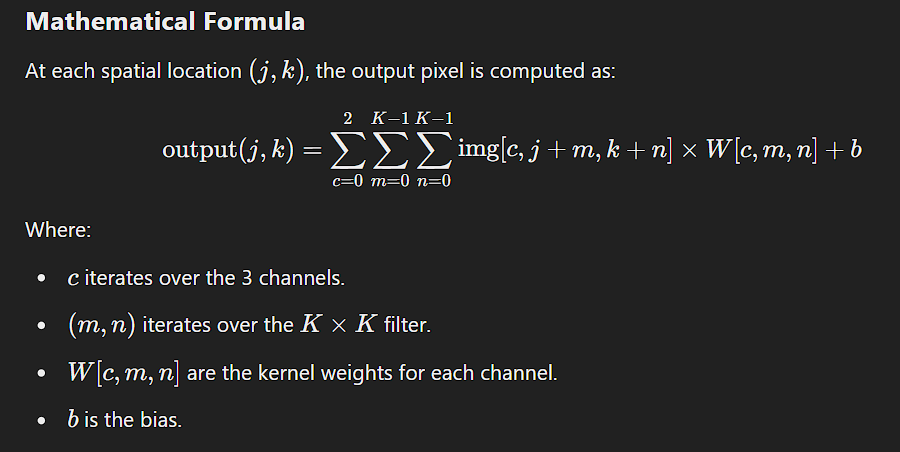

In [31]:
maxpool_layer_test = nn.MaxPool2d(kernel_size=2)

print("Shape of the image: ",test_image.shape)
conv_output = conv_layer_test(test_image)
print("Shape of Activation Map: ",conv_output.shape)
maxpooled_op = maxpool_layer_test(conv_output) 
print("Shape of maxpooled output: ",maxpooled_op.shape)

Shape of the image:  torch.Size([3, 28, 28])
Shape of Activation Map:  torch.Size([10, 26, 26])
Shape of maxpooled output:  torch.Size([10, 13, 13])


In [32]:
arr = torch.randn(size=(10,7,7))  # Shape: (10, 7, 7)

flatten = nn.Flatten(start_dim=0)  # Create the flatten layer
output = flatten(arr)   # Apply flatten operation

print(output.shape)  # Expected output shape


torch.Size([490])


In [33]:
class FashionMNISTModelV2(nn.Module):
    ''' 
        Lets replicate the model Tiny VGG
    '''
    def __init__(self,input_shape: int,hidden_units: int,output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(                        # feature filtering
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(  # these layers represents the features
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=490,
                      out_features=hidden_units*2),
            nn.ELU(),
            nn.Linear(in_features=hidden_units*2,
                      out_features=output_shape),
            nn.ELU()
        )

    def forward(self,x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        return self.classifier(x)




In [34]:
data = torch.randn(size=(32,1,28,28))

In [35]:
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)  # number of color channels
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=20, bias=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=20, out_features=10, bias=True)
    (4): ELU(alpha=1.0)
  )
)

In [36]:
output = model_2(data.to(device))
output.shape

torch.Size([32, 10])

In [37]:
class_names[torch.argmax(output[0])]

'Pullover'

Lets train our CNN model_2

In [38]:
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(params=model_2.parameters(),lr=0.01)

In [39]:
torch.cuda.manual_seed(42)

epochs = 50
test_acc_data2 = []
test_loss_data2 = []
train_acc_data2 = []
train_loss_data2 = []
epoch_count = [i for i in range(1, epochs+1)]

print("Training Model-2")
start_time = time.time()
for epoch in range(epochs):
    # Training
    loss_train,acc_train = training_step(model=model_2,
                                         data_loader=train_dataloader,
                                         loss_fn=loss_fn2,
                                         optimizer=optimizer2,
                                         epoch=epoch,
                                         device=device) 
    
    epoch_train_loss = loss_train / len(train_dataloader)
    epoch_train_acc = acc_train / len(train_dataloader)
    train_loss_data2.append(epoch_train_loss)
    train_acc_data2.append(epoch_train_acc)

    # Testing
    loss_test,acc_test = testing_step(model=model_2,
                                      data_loader=test_dataloader,
                                      loss_fn=loss_fn2,
                                      epoch=epoch,
                                      device=device)
        
    epoch_test_loss = loss_test / len(test_dataloader)
    epoch_test_acc = acc_test / len(test_dataloader)
    test_loss_data2.append(epoch_test_loss)
    test_acc_data2.append(epoch_test_acc)
    
    # Print final metrics for the epoch
    print(f"Epoch {epoch}: Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | Train Accuracy: {epoch_train_acc:.4f} | Test Accuracy: {epoch_test_acc:.4f}")
end_time = time.time()
model_2_training_time = end_time-start_time

Training Model-2


Epoch 0: Train Loss: 1.2656 | Test Loss: 0.6466 | Train Accuracy: 52.3283 | Test Accuracy: 75.8586


Epoch 1: Train Loss: 0.5789 | Test Loss: 0.5492 | Train Accuracy: 78.1583 | Test Accuracy: 79.6226


Epoch 2: Train Loss: 0.4784 | Test Loss: 0.4622 | Train Accuracy: 82.2917 | Test Accuracy: 83.2468


Epoch 3: Train Loss: 0.4242 | Test Loss: 0.4193 | Train Accuracy: 84.3233 | Test Accuracy: 84.7544


Epoch 4: Train Loss: 0.3923 | Test Loss: 0.3882 | Train Accuracy: 85.5800 | Test Accuracy: 85.8127


Epoch 5: Train Loss: 0.3689 | Test Loss: 0.3749 | Train Accuracy: 86.4233 | Test Accuracy: 86.4317


Epoch 6: Train Loss: 0.3537 | Test Loss: 0.3768 | Train Accuracy: 87.1683 | Test Accuracy: 86.4417


Epoch 7: Train Loss: 0.3384 | Test Loss: 0.3721 | Train Accuracy: 87.6250 | Test Accuracy: 86.5216


Epoch 8: Train Loss: 0.3271 | Test Loss: 0.3477 | Train Accuracy: 88.0450 | Test Accuracy: 87.4501


Epoch 9: Train Loss: 0.3160 | Test Loss: 0.3381 | Train Accuracy: 88.4417 | Test Accuracy: 87.8494


Epoch 10: Train Loss: 0.3081 | Test Loss: 0.3316 | Train Accuracy: 88.7317 | Test Accuracy: 88.1090


Epoch 11: Train Loss: 0.2999 | Test Loss: 0.3251 | Train Accuracy: 89.0117 | Test Accuracy: 88.4784


Epoch 12: Train Loss: 0.2929 | Test Loss: 0.3181 | Train Accuracy: 89.2733 | Test Accuracy: 88.5084


Epoch 13: Train Loss: 0.2853 | Test Loss: 0.3189 | Train Accuracy: 89.6067 | Test Accuracy: 88.5284


Epoch 14: Train Loss: 0.2797 | Test Loss: 0.3096 | Train Accuracy: 89.8567 | Test Accuracy: 88.7680


Epoch 15: Train Loss: 0.2744 | Test Loss: 0.3087 | Train Accuracy: 89.9867 | Test Accuracy: 88.8978


Epoch 16: Train Loss: 0.2682 | Test Loss: 0.2997 | Train Accuracy: 90.2767 | Test Accuracy: 89.3271


Epoch 17: Train Loss: 0.2636 | Test Loss: 0.2996 | Train Accuracy: 90.4800 | Test Accuracy: 89.2073


Epoch 18: Train Loss: 0.2583 | Test Loss: 0.3116 | Train Accuracy: 90.5750 | Test Accuracy: 89.1174


Epoch 19: Train Loss: 0.2547 | Test Loss: 0.3118 | Train Accuracy: 90.6817 | Test Accuracy: 88.8279


Epoch 20: Train Loss: 0.2509 | Test Loss: 0.2962 | Train Accuracy: 90.7700 | Test Accuracy: 89.5168


Epoch 21: Train Loss: 0.2461 | Test Loss: 0.2925 | Train Accuracy: 90.9600 | Test Accuracy: 89.7364


Epoch 22: Train Loss: 0.2420 | Test Loss: 0.2873 | Train Accuracy: 91.0900 | Test Accuracy: 89.7364


Epoch 23: Train Loss: 0.2389 | Test Loss: 0.2850 | Train Accuracy: 91.2817 | Test Accuracy: 90.1358


Epoch 24: Train Loss: 0.2344 | Test Loss: 0.2943 | Train Accuracy: 91.3733 | Test Accuracy: 89.9960


Epoch 25: Train Loss: 0.2323 | Test Loss: 0.2825 | Train Accuracy: 91.3967 | Test Accuracy: 90.0659


Epoch 26: Train Loss: 0.2296 | Test Loss: 0.2804 | Train Accuracy: 91.5383 | Test Accuracy: 89.9860


Epoch 27: Train Loss: 0.2270 | Test Loss: 0.2801 | Train Accuracy: 91.5717 | Test Accuracy: 89.7863


Epoch 28: Train Loss: 0.2242 | Test Loss: 0.2869 | Train Accuracy: 91.8350 | Test Accuracy: 89.6066


Epoch 29: Train Loss: 0.2218 | Test Loss: 0.2791 | Train Accuracy: 91.8800 | Test Accuracy: 90.2756


Epoch 30: Train Loss: 0.2191 | Test Loss: 0.2680 | Train Accuracy: 92.0600 | Test Accuracy: 90.7648


Epoch 31: Train Loss: 0.2160 | Test Loss: 0.2703 | Train Accuracy: 92.1667 | Test Accuracy: 90.3355


Epoch 32: Train Loss: 0.2142 | Test Loss: 0.2669 | Train Accuracy: 92.1000 | Test Accuracy: 90.4852


Epoch 33: Train Loss: 0.2118 | Test Loss: 0.2683 | Train Accuracy: 92.2367 | Test Accuracy: 90.5950


Epoch 34: Train Loss: 0.2092 | Test Loss: 0.2629 | Train Accuracy: 92.3083 | Test Accuracy: 90.5152


Epoch 35: Train Loss: 0.2066 | Test Loss: 0.2662 | Train Accuracy: 92.4133 | Test Accuracy: 90.5950


Epoch 36: Train Loss: 0.2047 | Test Loss: 0.2660 | Train Accuracy: 92.3933 | Test Accuracy: 90.3854


Epoch 37: Train Loss: 0.2031 | Test Loss: 0.2770 | Train Accuracy: 92.5683 | Test Accuracy: 89.9261


Epoch 38: Train Loss: 0.2008 | Test Loss: 0.2727 | Train Accuracy: 92.6933 | Test Accuracy: 90.0859


Epoch 39: Train Loss: 0.1985 | Test Loss: 0.2695 | Train Accuracy: 92.6750 | Test Accuracy: 90.4653


Epoch 40: Train Loss: 0.1970 | Test Loss: 0.2676 | Train Accuracy: 92.7600 | Test Accuracy: 90.4253


Epoch 41: Train Loss: 0.1959 | Test Loss: 0.2545 | Train Accuracy: 92.7267 | Test Accuracy: 90.9944


Epoch 42: Train Loss: 0.1927 | Test Loss: 0.2691 | Train Accuracy: 92.8350 | Test Accuracy: 90.4952


Epoch 43: Train Loss: 0.1909 | Test Loss: 0.2679 | Train Accuracy: 92.9650 | Test Accuracy: 90.3954


Epoch 44: Train Loss: 0.1892 | Test Loss: 0.2681 | Train Accuracy: 92.9767 | Test Accuracy: 90.6250


Epoch 45: Train Loss: 0.1879 | Test Loss: 0.2574 | Train Accuracy: 93.0750 | Test Accuracy: 90.9744


Epoch 46: Train Loss: 0.1848 | Test Loss: 0.2603 | Train Accuracy: 93.2183 | Test Accuracy: 90.6649


Epoch 47: Train Loss: 0.1841 | Test Loss: 0.2911 | Train Accuracy: 93.1650 | Test Accuracy: 89.8962


Epoch 48: Train Loss: 0.1831 | Test Loss: 0.2643 | Train Accuracy: 93.2800 | Test Accuracy: 91.0244


Epoch 49: Train Loss: 0.1812 | Test Loss: 0.2584 | Train Accuracy: 93.2867 | Test Accuracy: 91.0643


In [40]:
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn2)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.2586521535290602,
 'model_acc': 91.05431309904154}

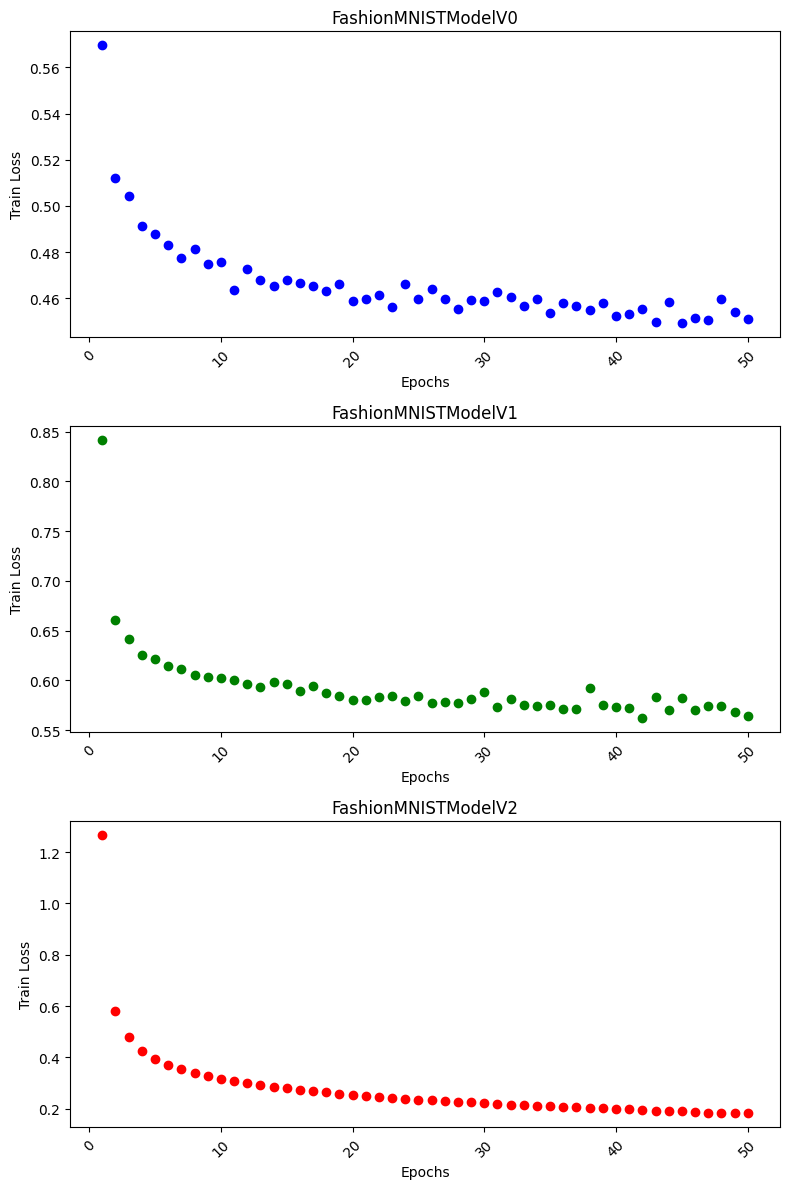

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))

# Model 0 plot
axes[0].scatter(epoch_count, train_loss_data0, color='blue')
axes[0].set_title("FashionMNISTModelV0")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Train Loss")
axes[0].tick_params(axis='x', rotation=45)

# Model 1 plot
axes[1].scatter(epoch_count, train_loss_data1, color='green')
axes[1].set_title("FashionMNISTModelV1")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Train Loss")
axes[1].tick_params(axis='x', rotation=45)

# Model 2 plot
axes[2].scatter(epoch_count, train_loss_data2, color='red')
axes[2].set_title("FashionMNISTModelV2")
axes[2].set_xlabel("Epochs")
axes[2].set_ylabel("Train Loss")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Comparing different Models

In [42]:
import pandas as pd

compare_result = pd.DataFrame(
    [model_0_results,model_1_results,model_2_results]
)
compare_result['training_time'] = [model_0_training_time,model_1_training_time,model_2_training_time]
compare_result

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.552265,82.957268,616.487378
1,FashionMNISTModelV1,0.662330,80.521166,644.538415
2,FashionMNISTModelV2,0.258652,91.054313,623.355458


(array([0, 1, 2]),
 [Text(0, 0, 'FashionMNISTModelV0'),
  Text(1, 0, 'FashionMNISTModelV1'),
  Text(2, 0, 'FashionMNISTModelV2')])

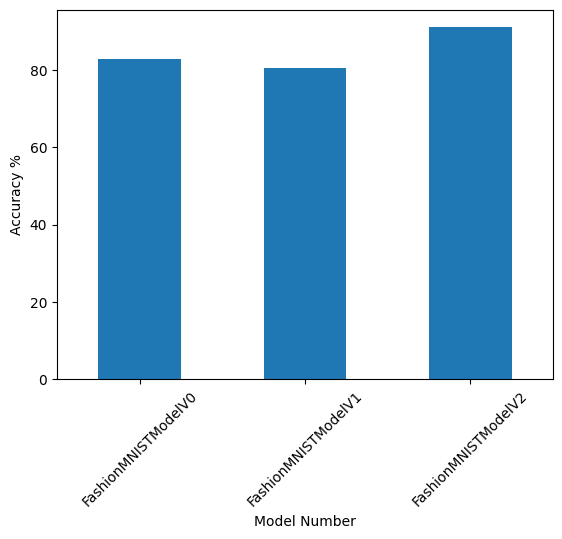

In [43]:
compare_result.set_index("model_name")["model_acc"].plot(kind="bar")
plt.xlabel("Model Number")
plt.ylabel("Accuracy %")
plt.xticks(rotation=45)

Make and evaluate random predictions with best model

In [54]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []

    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = sample.unsqueeze(dim=0).to(device)
            print(sample.shape)

            y_pred_logits = model(sample)  #1x10
            print(y_pred_logits.shape)

            pred_prob = torch.softmax(y_pred_logits.squeeze(),dim=0)
            pred_probs.append(pred_prob.cpu())

    # stacking the pred_probs to turn list into tensor
    return torch.stack(pred_probs)
            

In [55]:
import random

# random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape # 1,28,28 it will represent the image

torch.Size([1, 28, 28])

In [58]:
# make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

pred_labels = pred_probs.argmax(dim=1)

torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])


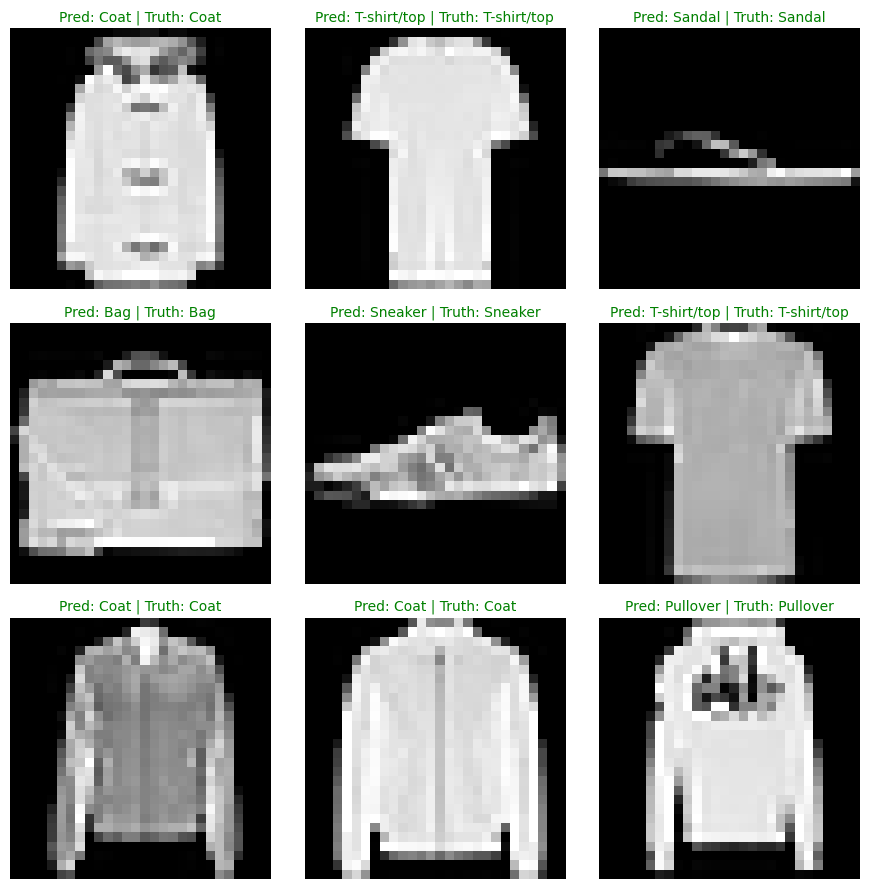

In [59]:
# plot predicitons

plt.figure(figsize=(9,9))

nrows=3
ncols=3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows,ncols,i+1)

    plt.imshow(sample.squeeze(),cmap="gray")

    pred_label = class_names[pred_labels[i]]
    truth_label = class_names[test_labels[i]]

    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text,fontsize=10,c="g")
    else:
        plt.title(title_text,fontsize=10,c="r")
    
    plt.axis('off')

plt.tight_layout()
plt.show()
